## Notebook description

+ This notebook uses as an input: 
    + Unique dataframe created in 2 - data_analysis

+ The objectives are 
    + Generate dataframe using just earning calls rows
    + Add topic modelling
    + Create baseline models
        + Linear regression
        + ML models

## Import libraries

In [62]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
import os
import spacy
from wordcloud import WordCloud

# modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score

import re
#adding the ec10 info
import topicmodelutils

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, HalvingGridSearchCV
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor,AdaBoostClassifier,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import gensim


## Import data

In [20]:
#Import base
stock_prices = pd.read_csv('../data/stock_prices_complete.csv')
stock_prices = stock_prices.drop(['Unnamed: 0'],axis=1)
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'],infer_datetime_format=True)
stock_prices.head()

,Date,Adj Close,Volume,Ticker,eps_mean,eps_mean_report,sp_500_closeprice,earning_call_date,content,10d_close_pct,...,rsi50,rsi200,por_change_1_week_val,por_change_1_month_val,por_change_1_quater_val,por_change_1_year_val,ma_5days_1month,ma_10days_1quarter,ma_20days_1year,eps_mean_report_pdif
0,2013-02-01,24.526785,9527500.0,ABBV,3.1,2.9,151.240005,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.451613
1,2013-02-04,24.592743,6348000.0,ABBV,3.1,2.9,149.539993,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.451613
2,2013-02-05,24.539970,7284400.0,ABBV,3.1,2.9,151.050003,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.451613
3,2013-02-06,24.500391,5738900.0,ABBV,3.1,2.9,151.160004,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.451613
4,2013-02-07,24.025429,9872500.0,ABBV,3.1,2.9,150.960007,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.451613


## Generating dataframe using earnings calls dates

+ Select dates with Earning Calls values

In [21]:
stock_prices_ec = stock_prices.dropna(subset=['content'])

+ Select dates with EPS values

In [22]:
stock_prices_ec = stock_prices_ec.dropna(subset=['eps_mean','eps_mean_report'])
stock_prices_ec = stock_prices_ec.reset_index()
stock_prices_ec = stock_prices_ec.drop(['index'],axis=1)
stock_prices_ec.head()

,Date,Adj Close,Volume,Ticker,eps_mean,eps_mean_report,sp_500_closeprice,earning_call_date,content,10d_close_pct,...,rsi50,rsi200,por_change_1_week_val,por_change_1_month_val,por_change_1_quater_val,por_change_1_year_val,ma_5days_1month,ma_10days_1quarter,ma_20days_1year,eps_mean_report_pdif
0,2013-04-26,30.519445,10096800.0,ABBV,3.11429,2.83000,158.240005,2013-04-26,Operator: Good morning and thank you for stand...,0.081387,...,69.768228,NaN,8.138732,13.448375,NaN,NaN,15.991188,NaN,NaN,-9.128565
1,2013-07-26,30.094526,4491100.0,ABBV,3.12750,2.69500,169.110001,2013-07-26,Operator: Good morning and thank you for stand...,0.006065,...,48.360002,NaN,0.606487,4.803558,2.754639,NaN,5.784629,1.133854,NaN,-13.828937
2,2013-10-25,33.423153,6956800.0,ABBV,3.13423,2.57500,175.949997,2013-10-25,Operator: Good morning and thank you for stand...,0.020070,...,62.209311,NaN,2.007011,12.213035,9.931589,NaN,9.212339,11.294156,NaN,-17.842660
3,2014-01-31,33.640068,12863500.0,ABBV,3.15143,2.98333,178.179993,2014-01-31,"Operator: Good morning, and thank you for stan...",0.030132,...,51.367162,53.582978,3.013166,-4.540313,1.763654,37.156452,-5.787309,1.526260,NaN,-5.334086
4,2014-04-25,33.879078,7289100.0,ABBV,3.13085,2.99275,186.289993,2014-04-25,Operator: Good morning and thank you for stand...,0.012152,...,48.411116,53.097360,1.215240,-4.026735,4.137344,11.008172,-4.533099,1.485603,19.582403,-4.410943


+ Saving dataframe

In [63]:
stock_prices_ec.to_csv('../data/stock_prices_ec.csv')

## Topic modeling

In [24]:
ec=topicmodelutils.topicdictcount.copy()
ec.date=pd.to_datetime(ec.date)
ec.drop(['index','result'], axis=1, inplace=True)
ec = ec.drop(['content'], axis=1)
ec.head()


,symbol,quarter,year,date,topic0,topic1,topic2,topic4,topic5,topic3,...,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg
0,PFE,4,2007,2008-01-24,0.145448,0.650248,0.050793,0.029116,0.117531,0.0,...,0.0,0.0,0.001792,0.0,0.019713,0.000000,0.001792,0.0,0.001792,0.000000
1,PFE,3,2007,2007-10-18,0.181578,0.577258,0.000000,0.032369,0.208566,0.0,...,0.0,0.0,0.000000,0.0,-0.002041,-0.006122,0.000000,0.0,0.000000,0.002041
2,PFE,2,2007,2007-07-18,0.207389,0.452576,0.040011,0.049867,0.250117,0.0,...,0.0,0.0,0.000000,0.0,-0.007317,0.002439,0.000000,0.0,0.000000,0.000000
3,PFE,4,2008,2009-01-28,0.254029,0.534936,0.020019,0.094598,0.096381,0.0,...,0.0,0.0,0.002747,0.0,0.024725,0.010989,0.000000,0.0,0.005495,0.000000
4,PFE,1,2008,2008-04-17,0.187469,0.584967,0.019077,0.062089,0.146357,0.0,...,0.0,0.0,0.000000,0.0,0.024048,0.004008,0.004008,0.0,0.002004,0.000000


In [25]:
stock_prices_ec = pd.merge(stock_prices_ec, ec, left_on=['Date', 'Ticker'], right_on=['date', 'symbol'])
stock_prices_ec.head()

,Date,Adj Close,Volume,Ticker,eps_mean,eps_mean_report,sp_500_closeprice,earning_call_date,content,10d_close_pct,...,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg
0,2013-04-26,30.519445,10096800.0,ABBV,3.11429,2.83000,158.240005,2013-04-26,Operator: Good morning and thank you for stand...,0.081387,...,0.000000,0.0,0.0,0.0,0.034230,0.002445,0.000000,0.0,0.000000,0.0
1,2013-07-26,30.094526,4491100.0,ABBV,3.12750,2.69500,169.110001,2013-07-26,Operator: Good morning and thank you for stand...,0.006065,...,0.004890,0.0,0.0,0.0,0.036675,0.002445,0.004890,0.0,0.000000,0.0
2,2013-10-25,33.423153,6956800.0,ABBV,3.13423,2.57500,175.949997,2013-10-25,Operator: Good morning and thank you for stand...,0.020070,...,0.000000,0.0,0.0,0.0,0.020979,0.004662,0.002331,0.0,0.000000,0.0
3,2014-01-31,33.640068,12863500.0,ABBV,3.15143,2.98333,178.179993,2014-01-31,"Operator: Good morning, and thank you for stan...",0.030132,...,0.005405,0.0,0.0,0.0,0.048649,0.005405,0.010811,0.0,0.002703,0.0
4,2014-04-25,33.879078,7289100.0,ABBV,3.13085,2.99275,186.289993,2014-04-25,Operator: Good morning and thank you for stand...,0.012152,...,0.004785,0.0,0.0,0.0,0.038278,0.004785,0.004785,0.0,0.000000,0.0


In [26]:
#Drop noisy variables
stock_prices_ec = stock_prices_ec.drop(['symbol','earning_call_date','quarter', 'year', 'date'],axis = 1)


,Date,Adj Close,Volume,Ticker,eps_mean,eps_mean_report,sp_500_closeprice,content,10d_close_pct,10d_future_close,...,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg
0,2013-04-26,30.519445,10096800.0,ABBV,3.11429,2.83000,158.240005,Operator: Good morning and thank you for stand...,0.081387,29.747131,...,0.000000,0.000000,0.00000,0.0,0.034230,0.002445,0.000000,0.000000,0.000000,0.00000
1,2013-07-26,30.094526,4491100.0,ABBV,3.12750,2.69500,169.110001,Operator: Good morning and thank you for stand...,0.006065,30.450632,...,0.004890,0.000000,0.00000,0.0,0.036675,0.002445,0.004890,0.000000,0.000000,0.00000
2,2013-10-25,33.423153,6956800.0,ABBV,3.13423,2.57500,175.949997,Operator: Good morning and thank you for stand...,0.020070,33.192654,...,0.000000,0.000000,0.00000,0.0,0.020979,0.004662,0.002331,0.000000,0.000000,0.00000
3,2014-01-31,33.640068,12863500.0,ABBV,3.15143,2.98333,178.179993,"Operator: Good morning, and thank you for stan...",0.030132,33.407730,...,0.005405,0.000000,0.00000,0.0,0.048649,0.005405,0.010811,0.000000,0.002703,0.00000
4,2014-04-25,33.879078,7289100.0,ABBV,3.13085,2.99275,186.289993,Operator: Good morning and thank you for stand...,0.012152,35.285534,...,0.004785,0.000000,0.00000,0.0,0.038278,0.004785,0.004785,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,2019-02-21,155.740005,400100.0,ROG,18.30267,16.15267,277.420013,Operator: Good day. My name is Chantal and I'l...,0.173979,155.250000,...,0.008097,0.000000,0.00000,0.0,0.048583,0.004049,0.048583,0.000000,0.000000,0.00000
471,2019-05-01,190.820007,1213800.0,ROG,18.58821,16.61458,291.809998,Operator: Good day. My name is Kelly and I wil...,0.111810,184.039993,...,0.020270,0.000000,0.00000,0.0,0.054054,0.006757,0.050676,0.000000,0.000000,0.00000
472,2019-08-01,153.339996,376200.0,ROG,19.05825,16.77461,294.839996,Operator: Good day. My name is Jason and I wil...,-0.110041,141.089996,...,0.012397,0.004132,0.00000,0.0,0.066116,0.008264,0.037190,0.008264,0.000000,0.00000
473,2020-02-21,110.180000,413900.0,ROG,20.45850,17.79106,333.480011,Operator: Good day. My name is Erica and I wil...,-0.043659,116.000000,...,0.003390,-0.003390,0.00339,0.0,0.037288,0.010169,0.023729,-0.003390,0.006780,0.00339


## Split and impute data

+ According to time

In [27]:
#Dates just for the proportion

train_df = stock_prices_ec[stock_prices_ec.Date <= '2018-12-31']
test_df = stock_prices_ec[stock_prices_ec.Date > '2018-12-31']

train_df = train_df.dropna(subset=['10d_future_close_pct'])
test_df = test_df.dropna(subset=['10d_future_close_pct'])

ec_train = train_df.filter(['content'],axis=1)
ec_test = train_df.filter(['content'],axis=1)



#X_train = train_df.drop(['Adj Close','Target','Target_norm','Date','content','10d_future_close_pct'],axis=1)
X_train = train_df.drop(['Adj Close','Date','content','10d_future_close_pct'],axis=1)

y_train = train_df.filter(['10d_future_close_pct'],axis=1)

#X_test = test_df.drop(['Adj Close','Target','Target_norm','Date','content','10d_future_close_pct'],axis=1)
X_test = test_df.drop(['Adj Close','Date','content','10d_future_close_pct'],axis=1)
y_test = test_df.filter(['10d_future_close_pct'],axis=1)

print(len(train_df))
print(len(test_df))


368
107


+ Impute data

In [28]:
#Numerical
cont_imputer = KNNImputer(n_neighbors=5, weights = 'uniform', add_indicator=False) 
#Categorical
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

+ Scaler

In [29]:
cont_scaler = RobustScaler()
cat_scaler = StandardScaler()

#### Preprocessing Pipeline

We use the `ColumnTransformer` to allow for different data preprocessing for different types of columns

+ Numerical values - `RobustScaler()` and `KNNImputer()`
+ Categoricals - `OneHotEncoder()` and `StandardScaler()`

In [30]:
# Update list of numerical and categorical features
num_feat = X_train.select_dtypes(exclude=['object', 'category']).columns
print(num_feat)

cat_feat = X_train.select_dtypes(include=['object', 'category']).columns
print(cat_feat)

Index(['Volume', 'eps_mean', 'eps_mean_report', 'sp_500_closeprice',
       '10d_close_pct', '10d_future_close', 'ma5', 'ma14', 'ma50', 'ma200',
       'rsi5', 'rsi14', 'rsi50', 'rsi200', 'por_change_1_week_val',
       'por_change_1_month_val', 'por_change_1_quater_val',
       'por_change_1_year_val', 'ma_5days_1month', 'ma_10days_1quarter',
       'ma_20days_1year', 'eps_mean_report_pdif', 'topic0', 'topic1', 'topic2',
       'topic4', 'topic5', 'topic3', 't1', 't2', 't3', 't4', 't5', 't6', 't1d',
       't2d', 't3d', 't4d', 't5d', 't6d', 't1dg', 't2dg', 't3dg', 't4dg',
       't5dg', 't6dg'],
      dtype='object')
Index(['Ticker'], dtype='object')


In [31]:
# pipeline for numerical data
num_preprocessing = make_pipeline(
    cont_scaler,
    cont_imputer   
    )

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    cat_encoder,
    cat_scaler)

# combine preprocessing pipelines using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_feat),
     ("cat", cat_preprocessing, cat_feat)
     ]
    #,remainder='passthrough'
    , remainder='drop'
)

In [32]:
set_config(display="diagram")
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('knnimputer', KNNImputer())]),
                                 Index(['Volume', 'eps_mean', 'eps_mean_report', 'sp_500_closeprice',
       '10d_close_pct', '10d_future_close', 'ma5', 'ma14', 'ma50', 'ma200',
       'rsi5', 'rsi14', 'rsi50', 'rsi200', 'por_change_1_week_val',
       'por_change_1_month_val', 'por_change_1_quater_val...
       'ma_20days_1year', 'eps_mean_report_pdif', 'topic0', 'topic1', 'topic2',
       'topic4', 'topic5', 'topic3', 't1', 't2', 't3', 't4', 't5', 't6', 't1d',
       't2d', 't3d', 't4d', 't5d', 't6d', 't1dg', 't2dg', 't3dg', 't4dg',
       't5dg', 't6dg'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Ticker'], dtype='object'))])

In [33]:
#Fitting the model
preprocessing.fit(X_train, y_train)
X_train_pp = preprocessing.transform(X_train)

In [34]:
# Extract the fitted transformers
num_pipeline = preprocessing.named_transformers_['num']
cat_pipeline = preprocessing.named_transformers_['cat']

# Extract the encoders from the pipelines
fitted_cat_encoder = cat_pipeline.named_steps['onehotencoder']

# Get feature names from the categorical encoder
cat_columns = fitted_cat_encoder.get_feature_names_out(cat_feat)

# Combine all column names
all_columns = np.concatenate([num_feat, cat_columns])

# Convert the preprocessed data to a DataFrame
X_train_df = pd.DataFrame(X_train_pp, columns=all_columns)

In [35]:
#Applying the preprocessing to the test dataframe

X_test_pp = preprocessing.transform(X_test)
X_test_df = pd.DataFrame(X_test_pp, columns=all_columns)

In [36]:
#Checking common features

print("Features in train data but not in test:")
print(X_train_df.columns.difference(X_test_df.columns) )

print("\nFeatures in test data but not in train:")
print(X_test_df.columns.difference(X_train_df.columns) )

Features in train data but not in test:
Index([], dtype='object')

Features in test data but not in train:
Index([], dtype='object')


## Models

In [37]:
#Define seed 
SEED = 4

#Define X_train and X_test
X_train = X_train_df
X_test = X_test_df

### 1.Regression models
 + Dataframe without standarzization

In [38]:
train_df_ws = train_df.dropna()
test_df_ws = test_df.dropna()

#### Model 1.1 Linear model with price and volume only

In [39]:
# defining features and targte for this model
features = ['Volume', '10d_close_pct']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

train_df_ws = train_df_ws.set_index(['Date', 'Ticker'])
test_df_ws = test_df_ws.set_index(['Date', 'Ticker'])

# defining train and test set for this model
train_features, train_targets = train_df_ws[features], train_df_ws[target]
test_features, test_targets = train_df_ws[features], train_df_ws[target]

In [40]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.044
Model:                              OLS   Adj. R-squared:                  0.039
Method:                   Least Squares   F-statistic:                     8.231
Date:                  Wed, 14 Jun 2023   Prob (F-statistic):           0.000320
Time:                          18:55:22   Log-Likelihood:                 1313.4
No. Observations:                   362   AIC:                            -2621.
Df Residuals:                       359   BIC:                            -2609.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004  

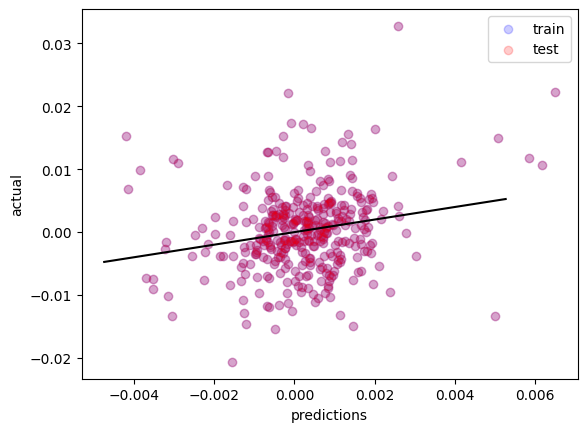

In [41]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### Model 1.2 Linear model with price, volume and other technical indicators data

In [42]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df_ws[features], train_df_ws[target]
test_features, test_targets = test_df_ws[features], test_df_ws[target]

In [43]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.082
Model:                              OLS   Adj. R-squared:                  0.056
Method:                   Least Squares   F-statistic:                     3.127
Date:                  Wed, 14 Jun 2023   Prob (F-statistic):           0.000768
Time:                          18:55:22   Log-Likelihood:                 1320.8
No. Observations:                   362   AIC:                            -2620.
Df Residuals:                       351   BIC:                            -2577.
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0010  

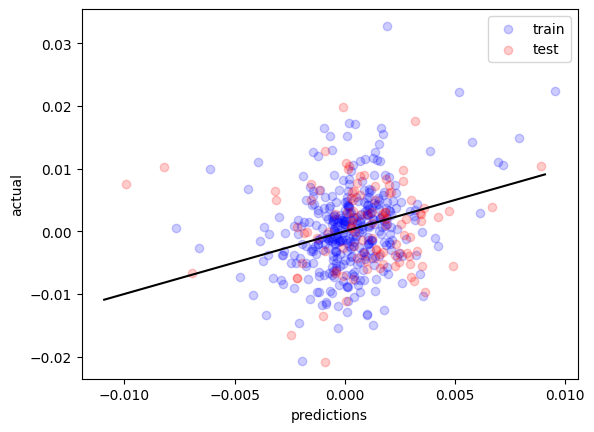

In [44]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### Model 1.3 Linear model with price, volume, technical indicators data and balance sheet data

In [45]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200','eps_mean_report','eps_mean_report_pdif','eps_mean']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df_ws[features], train_df_ws[target]
test_features, test_targets = test_df_ws[features], test_df_ws[target]

In [46]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.091
Model:                              OLS   Adj. R-squared:                  0.057
Method:                   Least Squares   F-statistic:                     2.693
Date:                  Wed, 14 Jun 2023   Prob (F-statistic):            0.00125
Time:                          18:55:22   Log-Likelihood:                 1322.7
No. Observations:                   362   AIC:                            -2617.
Df Residuals:                       348   BIC:                            -2563.
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const       

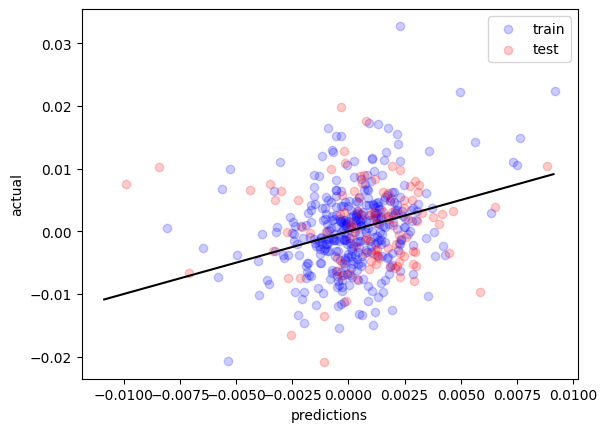

In [47]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()


#### Model 1.4 Linear model with price, volume, technical indicators, balance sheet data and porcentual lag variables

In [48]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200','eps_mean_report','eps_mean_report_pdif','eps_mean','por_change_1_week_val', 'por_change_1_month_val',
       'por_change_1_quater_val', 'por_change_1_year_val']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df_ws[features], train_df_ws[target]
test_features, test_targets = test_df_ws[features], test_df_ws[target]

In [49]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.096
Model:                              OLS   Adj. R-squared:                  0.054
Method:                   Least Squares   F-statistic:                     2.293
Date:                  Wed, 14 Jun 2023   Prob (F-statistic):            0.00333
Time:                          18:55:23   Log-Likelihood:                 1323.6
No. Observations:                   362   AIC:                            -2613.
Df Residuals:                       345   BIC:                            -2547.
Df Model:                            16                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

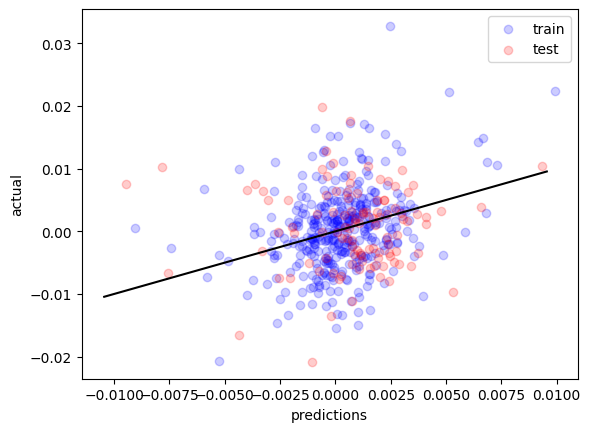

In [50]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()


#### Model 1.5 Linear model with price, volume, technical indicators, balance sheet data, porcentual lag variables and text features

In [51]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200','eps_mean_report','eps_mean_report_pdif','eps_mean','por_change_1_week_val', 'por_change_1_month_val',
       'por_change_1_quater_val', 'por_change_1_year_val'] +['topic0','topic1','topic2','topic3', 'topic4','topic5']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = train_df_ws[features], train_df_ws[target]
test_features, test_targets = test_df_ws[features], test_df_ws[target]


In [52]:
# Add a constant to the features
train_features = sm.add_constant(train_features)
test_features = sm.add_constant(test_features)

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)




                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.137
Model:                              OLS   Adj. R-squared:                  0.081
Method:                   Least Squares   F-statistic:                     2.441
Date:                  Wed, 14 Jun 2023   Prob (F-statistic):           0.000391
Time:                          18:55:23   Log-Likelihood:                 1331.9
No. Observations:                   362   AIC:                            -2618.
Df Residuals:                       339   BIC:                            -2528.
Df Model:                            22                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

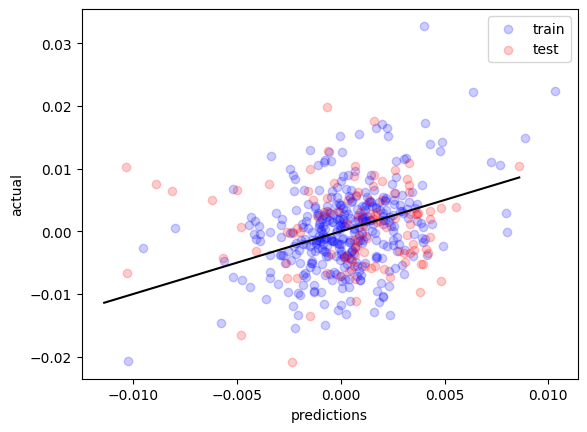

In [53]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

### 2.Machine Learning models

#### Model 2.1 ML model with price, volume and other technical indicators data without EPS

In [54]:
# we could also add interaction terms and see how they perform
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature


# defining train and test set for this model
train_features, train_targets = X_train[features], y_train
test_features, test_targets = X_test[features], y_test

+ Define models

In [55]:
# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Halving-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='r2', verbose = 0) #using R2 as metric for scoring
    best_model.fit(train_features, train_targets)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} R2 score on train sample: {-best_model.best_score_}')

Halving-Searching for model DecisionTree_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 9, 'random_state': 4}
DecisionTree_Regressor R2 score on train sample: 0.199992424052963
Halving-Searching for model RandomForest_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y wa

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 6, 'n_estimators': 100, 'random_state': 4}
RandomForest_Regressor R2 score on train sample: 0.06276216764934237
Halving-Searching for model AdaBoost_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 1, 'loss': 'linear', 'n_estimators': 50, 'random_state': 4}
AdaBoost_Regressor R2 score on train sample: 0.096670190869738
Halving-Searching for model GradientBoosting_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 7, 'n_estimators': 50, 'random_state': 4}
GradientBoosting_Regressor R2 score on train sample: 0.0884661925280158


/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [56]:
#printing the best model
best_model

HalvingGridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                        max_features=7,
                                                        n_estimators=50,
                                                        random_state=4),
                    n_jobs=4,
                    param_grid={'learning_rate': [0.05, 1],
                                'max_depth': range(3, 6),
                                'max_features': range(4, 10),
                                'n_estimators': [50, 100],
                                'random_state': [4]},
                    scoring='r2')

In [57]:
# getting the predictions for the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)

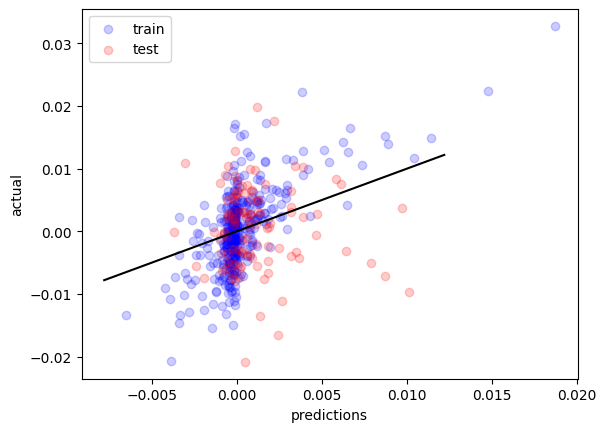

In [58]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### Model 2.2 ML model with price, volume and other technical indicators data with EPS

Grid-Searching for model DecisionTree_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 8, 'random_state': 4}
DecisionTree_Regressor R2 score on train sample: 0.11939106495654003
Grid-Searching for model RandomForest_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y wa

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 9, 'n_estimators': 50, 'random_state': 4}
RandomForest_Regressor R2 score on train sample: 0.03975757935285464
Grid-Searching for model AdaBoost_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 100, 'random_state': 4}
AdaBoost_Regressor R2 score on train sample: 0.05051904373610507
Grid-Searching for model GradientBoosting_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 4, 'n_estimators': 50, 'random_state': 4}
GradientBoosting_Regressor R2 score on train sample: 0.07605240354639062


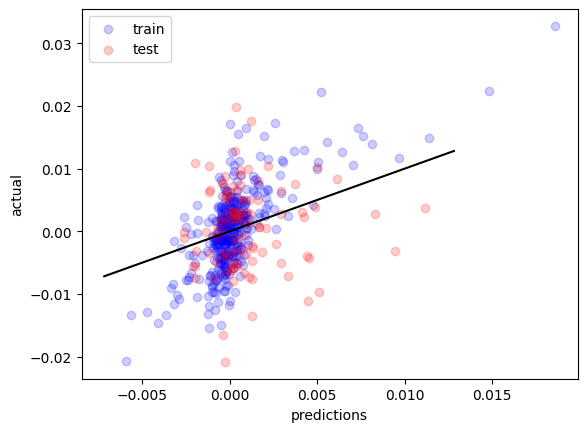

In [59]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200','eps_mean_report','eps_mean_report_pdif','eps_mean']
target = '10d_future_close_pct'

# defining train and test set for this model
train_features, train_targets = X_train[features], y_train
test_features, test_targets = X_test[features], y_test

# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='r2', verbose = 0) #using R2 as metric for scoring
    best_model.fit(train_features, train_targets)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} R2 score on train sample: {-best_model.best_score_}')
#printing the best model
best_model
# getting the predictions for the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### Model 2.3 ML model with price, volume, technical indicators data and balance sheet data

Grid-Searching for model DecisionTree_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 6, 'random_state': 4}
DecisionTree_Regressor R2 score on train sample: 0.18001265762499663
Grid-Searching for model RandomForest_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y wa

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 4}
RandomForest_Regressor R2 score on train sample: 0.05897210007546416
Grid-Searching for model AdaBoost_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50, 'random_state': 4}
AdaBoost_Regressor R2 score on train sample: 0.05193412439910276
Grid-Searching for model GradientBoosting_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 1, 'max_depth': 5, 'max_features': 9, 'n_estimators': 100, 'random_state': 4}
GradientBoosting_Regressor R2 score on train sample: 1.1838610357168464


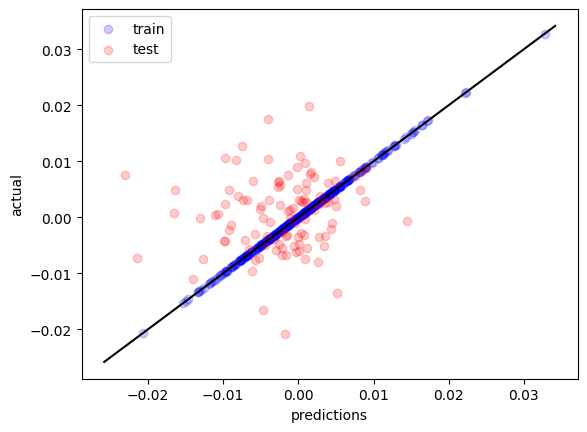

In [60]:
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200','eps_mean_report','eps_mean_report_pdif','eps_mean','por_change_1_week_val', 'por_change_1_month_val',
       'por_change_1_quater_val', 'por_change_1_year_val']
target = '10d_future_close_pct'

# defining train and test set for this model
train_features, train_targets = X_train[features], y_train
test_features, test_targets = X_test[features], y_test

# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='r2', verbose = 0) #using R2 as metric for scoring
    best_model.fit(train_features, train_targets)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} R2 score on train sample: {-best_model.best_score_}')
#printing the best model
best_model
# getting the predictions for the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

#### Model 2.4 ML model with price, volume, technical indicators, balance sheet data and text features

Grid-Searching for model DecisionTree_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn

Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 9, 'random_state': 4}
DecisionTree_Regressor R2 score on train sample: 0.10834710989880023
Grid-Searching for model RandomForest_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y wa

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 4, 'max_features': 5, 'min_samples_leaf': 9, 'n_estimators': 100, 'random_state': 4}
RandomForest_Regressor R2 score on train sample: 0.07027648462005968
Grid-Searching for model AdaBoost_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 100, 'random_state': 4}
AdaBoost_Regressor R2 score on train sample: 0.027577370847515038
Grid-Searching for model GradientBoosting_Regressor...


/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vl/.venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 6, 'n_estimators': 50, 'random_state': 4}
GradientBoosting_Regressor R2 score on train sample: 0.06082166770488513


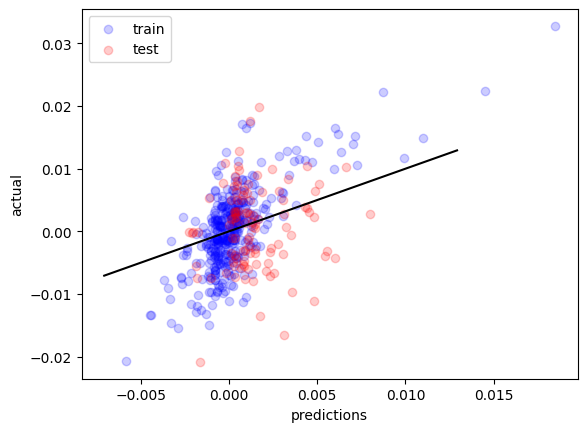

In [61]:
# we could also add interaction terms and see how they perform
# defining features and targte for this model
features = [ 'Volume', '10d_close_pct', 'ma5', 'rsi5', 
            'ma14', 'rsi14', 'ma50', 'rsi50','ma200', 'rsi200']+['topic0','topic1','topic2','topic3', 'topic4','topic5']
target = '10d_future_close_pct' #since the task is predict return we will put the return and not the price as feature

# defining train and test set for this model
train_features, train_targets = X_train[features], y_train
test_features, test_targets = X_test[features], y_test

# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='r2', verbose = 0) #using R2 as metric for scoring
    best_model.fit(train_features, train_targets)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} R2 score on train sample: {-best_model.best_score_}')
#printing the best model
best_model
# getting the predictions for the best model
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()